In [1]:
# default_exp modeling.single_frame_model

In [2]:
#export
from dfdc.modeling.dataset_utils import *
from fastai.vision import *

In [5]:
data_path = Path("/home/ubuntu/data/dfdc"); data_path.ls()

[PosixPath('/home/ubuntu/data/dfdc/dfdc_face_detections'),
 PosixPath('/home/ubuntu/data/dfdc/dfdc_cropped_faces'),
 PosixPath('/home/ubuntu/data/dfdc/dfdc_training_csv'),
 PosixPath('/home/ubuntu/data/dfdc/cookies.txt'),
 PosixPath('/home/ubuntu/data/dfdc/dfdc_train')]

In [6]:
cropped_path = data_path/'dfdc_cropped_faces'; print(cropped_path)

/home/ubuntu/data/dfdc/dfdc_cropped_faces


In [8]:
training_csv_path = data_path/'dfdc_training_csv'; print(trainind_csv_path)

/home/ubuntu/data/dfdc/dfdc_training_csv


In [18]:
train_parts = list(range(40))
valid_parts = list(range(40,45))
test_parts = list(range(45,50))

In [19]:
len(train_parts), len(test_parts), len(test_parts)

(40, 5, 5)

In [46]:
def read_train_csv(fname):
    df = pd.read_csv(fname, usecols=['fname', 'label', 'original', 'source', 'face_crop_fnames'])
    df['face_crop_fnames'] = df['face_crop_fnames'].apply(eval)
    return df

In [47]:
train_dfs = [read_train_csv(trainind_csv_path/f'part_{part_no}_training.csv') for part_no in train_parts]
valid_dfs = [read_train_csv(trainind_csv_path/f'part_{part_no}_training.csv' )for part_no in valid_parts]
test_dfs = [read_train_csv(trainind_csv_path/f'part_{part_no}_training.csv') for part_no in test_parts]

In [48]:
train_df = pd.concat(train_dfs).reset_index(drop=True)
valid_df = pd.concat(valid_dfs).reset_index(drop=True)
test_df = pd.concat(test_dfs).reset_index(drop=True)

In [49]:
train_df.shape, valid_df.shape, test_df.shape

((92724, 5), (12111, 5), (12367, 5))

In [71]:
train_df.head(4)

,fname,label,original,source,face_crop_fnames
0,owxbbpjpch.mp4,FAKE,wynotylpnm.mp4,wynotylpnm.mp4,"[dfdc_train_part_0/owxbbpjpch/frame_1_30.jpg, ..."
1,bpguesjrfa.mp4,FAKE,wynotylpnm.mp4,wynotylpnm.mp4,"[dfdc_train_part_0/bpguesjrfa/frame_1_30.jpg, ..."
2,skewcclbhg.mp4,FAKE,wynotylpnm.mp4,wynotylpnm.mp4,"[dfdc_train_part_0/skewcclbhg/frame_1_30.jpg, ..."
3,ybdtkypwez.mp4,FAKE,wynotylpnm.mp4,wynotylpnm.mp4,"[dfdc_train_part_0/ybdtkypwez/frame_1_30.jpg, ..."


In [51]:
train_df['face_crop_fnames'][0]

['dfdc_train_part_0/owxbbpjpch/frame_1_30.jpg',
 'dfdc_train_part_0/owxbbpjpch/frame_2_30.jpg',
 'dfdc_train_part_0/owxbbpjpch/frame_3_30.jpg',
 'dfdc_train_part_0/owxbbpjpch/frame_4_30.jpg',
 'dfdc_train_part_0/owxbbpjpch/frame_5_30.jpg',
 'dfdc_train_part_0/owxbbpjpch/frame_6_30.jpg',
 'dfdc_train_part_0/owxbbpjpch/frame_7_30.jpg',
 'dfdc_train_part_0/owxbbpjpch/frame_8_30.jpg',
 'dfdc_train_part_0/owxbbpjpch/frame_9_30.jpg',
 'dfdc_train_part_0/owxbbpjpch/frame_10_30.jpg',
 'dfdc_train_part_0/owxbbpjpch/frame_11_30.jpg',
 'dfdc_train_part_0/owxbbpjpch/frame_12_30.jpg',
 'dfdc_train_part_0/owxbbpjpch/frame_13_30.jpg',
 'dfdc_train_part_0/owxbbpjpch/frame_14_30.jpg',
 'dfdc_train_part_0/owxbbpjpch/frame_15_30.jpg',
 'dfdc_train_part_0/owxbbpjpch/frame_16_30.jpg',
 'dfdc_train_part_0/owxbbpjpch/frame_17_30.jpg',
 'dfdc_train_part_0/owxbbpjpch/frame_18_30.jpg',
 'dfdc_train_part_0/owxbbpjpch/frame_19_30.jpg',
 'dfdc_train_part_0/owxbbpjpch/frame_20_30.jpg',
 'dfdc_train_part_0/owxbbpjpc

### Single Frame Batch Sampler

- Permutate original videos
- Pick a random fake for each original video
- Pick same random single frame for both original video and selected fake 
- Original and it's fake should be in same batch - Consistency Loss for focusing on alteration areas

In [56]:
unique_originals = np.unique((train_df.original).dropna()); len(unique_originals)

14634

In [82]:
fname2idx = {k:v for v,k in enumerate(train_df['fname'])} # get indexes for batch yield

In [66]:
source2fakes = defaultdict(list)
for _, row in train_df.iterrows():
    if row['source'] != row['fname']:
        source2fakes[row['source']].append(row['fname'])

In [70]:
for k,v in source2fakes.items(): assert len(v) > 0 # each original should have at least 1 fake

In [63]:
unique_originals = np.random.permutation(unique_originals) # shuffle original videos

In [98]:
# collect indexes for source and fake
all_idxs = []
for source in unique_originals: 
    fake = np.random.choice(source2fakes[source])
    all_idxs.append((fname2idx[source], fname2idx[fake]))

In [101]:
face_crop_fnames = train_df['face_crop_fnames'].values

In [137]:
for (source_idx, fake_idx) in all_idxs: pass

In [138]:
source_idx, fake_idx

(91253, 91256)

In [139]:
assert len(face_crop_fnames[source_idx]) == len(face_crop_fnames[fake_idx])

In [140]:
rand_crop_idx = np.random.choice(range(len(face_crop_fnames[source_idx])))

In [141]:
rand_crop_idx

15

In [142]:
source_crop_fname = face_crop_fnames[source_idx][rand_crop_idx]
fake_crop_fname = face_crop_fnames[fake_idx][rand_crop_idx]

In [145]:
source_crop_fname, fake_crop_fname

('dfdc_train_part_39/xcdkppxfby/frame_16_30.jpg',
 'dfdc_train_part_39/xiwycfcnhi/frame_16_30.jpg')

In [151]:
class SingleFrameRealFakeSampler(Sampler):
    
    def __init__(self, train_df):
        
        self.train_df = train_df
        self.unique_originals = np.unique((self.train_df.original).dropna())
        
        # get fname indexes for sampling
        fname2idx = {k:v for v,k in enumerate(self.train_df['fname'])} 
        
        # get source 2 fake mapping 
        self.source2fakes = defaultdict(list)
        for _, row in train_df.iterrows():
            if row['source'] != row['fname']:
                self.source2fakes[row['source']].append(row['fname'])
        
        # each original should have at least 1 fake
        for k,v in self.source2fakes.items(): assert len(v) > 0
        
        # convert face crop fnames to array
        self.face_crop_fnames = self.train_df['face_crop_fnames'].values
        
        
    def __iter__(self):
        # shuffle original videos
        unique_originals = np.random.permutation(self.unique_originals)
        
        # collect indexes for source and fake
        all_idxs = []
        for source in unique_originals: 
            fake = np.random.choice(source2fakes[source])
            source_fname_idx = fname2idx[source]
            fake_fname_idx = fname2idx[fake]
            
            # pick a random frame for real and fake
            rand_crop_idx = np.random.choice(range(len(self.face_crop_fnames[source_fname_idx])))
            
            # real video, fake video, random frame
            all_idxs.append((source_fname_idx, fake_fname_idx, rand_crop_idx))
        
        return iter(all_idxs)
    
    def __len__(self):
        return len(self.unique_originals)*2

In [226]:
class SingleFrameRealFakeBatchSampler(Sampler):

    def __init__(self, sampler, batch_size, drop_last):
        self.sampler = sampler
        self.batch_size = batch_size
        self.drop_last = drop_last

    def __iter__(self):
        batch = []
        for real_idx, fake_idx, crop_idx in self.sampler:
            batch.append((real_idx, crop_idx))
            batch.append((fake_idx, crop_idx))
            if len(batch) == self.batch_size:
                yield batch
                batch = []
        if len(batch) > 0 and not self.drop_last:
            yield batch

    def __len__(self):
        if self.drop_last:
            return len(self.sampler) // self.batch_size
        else:
            return (len(self.sampler) + self.batch_size - 1) // self.batch_size

In [321]:
#export
class SingleFrameRealFakeDataset(Dataset):
    def __init__(self, cropped_path, df, sampler):
        self.sampler = sampler
        self.cropped_path = cropped_path
        self.df = df
        self.face_crop_fnames = df['face_crop_fnames'].values
        self.labels = df['label'].map({"REAL":0, "FAKE":1}).values
        
    def __getitem__(self, idxs:Tuple):
        fname_idx, crop_idx = idxs
        crop_fname = self.face_crop_fnames[fname_idx][crop_idx]
        img = open_image(cropped_path/crop_fname).resize(224).data 
        img = normalize(img, *[tensor(o) for o in imagenet_stats])
        label = self.labels[fname_idx]
        return img, label
    
    def __len__(self): return len(self.sampler)

In [322]:
class SingleFrameValidSampler(Sampler):
    def __init__(self, valid_df):
        valid_idxs = []
        valid_face_crop_fnames = valid_df.face_crop_fnames.values
        for i, l in enumerate(valid_face_crop_fnames):
            j = np.random.choice(range(len(l)))
            valid_idxs.append((i,j))
        self.valid_idxs = valid_idxs
        
    def __iter__(self): return iter(self.valid_idxs)
    def __len__(self): return len(self.valid_idxs)

In [ ]:
sampler = SingleFrameRealFakeSampler(train_df)
batch_sampler = SingleFrameRealFakeBatchSampler(sampler, 128, False)

In [324]:
train_ds = SingleFrameRealFakeDataset(cropped_path, train_df, sampler)
train_dl = DataLoader(train_ds, batch_sampler=batch_sampler, num_workers=defaults.cpus)

In [325]:
sampler = SingleFrameValidSampler(valid_df)
valid_ds = SingleFrameRealFakeDataset(cropped_path, valid_df, sampler)
valid_dl = DataLoader(valid_ds, 128, sampler=sampler, num_workers=defaults.cpus)

### transfer learning

In [326]:
data = DataBunch(train_dl, valid_dl); data.c = 2

In [327]:
learner = cnn_learner(data, models.resnet34)

In [328]:
learner.loss_func = CrossEntropyFlat()

In [329]:
learner.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


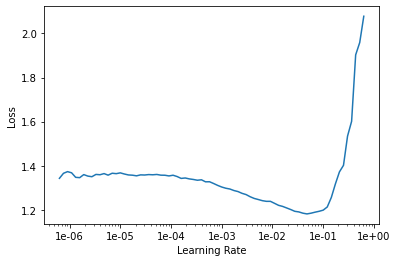

In [330]:
learner.recorder.plot()

In [ ]:
lr=1e-2
learner.fit_one_cycle(100, slice(lr))

In [ ]:
learner.freeze_to(1)
learner.fit_one_cycle(100, slice(lr/3))

In [ ]:
learner.unfreeze()
learner.fit_one_cycle(100, slice(lr/9))

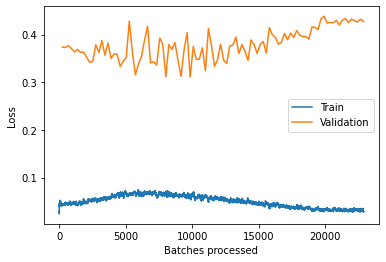

In [336]:
learner.recorder.plot_losses()

In [337]:
learner.save("single_frame_model_resnet34")

In [338]:
learner.validate()

[0.42703903]

In [45]:
preds = learner.get_preds()

### test

In [341]:
test_df.head()

,fname,label,original,source,face_crop_fnames
0,gthvvygfcj.mp4,FAKE,lxeqbyddvt.mp4,lxeqbyddvt.mp4,"[dfdc_train_part_45/gthvvygfcj/frame_1_30.jpg,..."
1,lxeqbyddvt.mp4,REAL,NaN,lxeqbyddvt.mp4,"[dfdc_train_part_45/lxeqbyddvt/frame_1_30.jpg,..."
2,rmgmravhdx.mp4,FAKE,lxeqbyddvt.mp4,lxeqbyddvt.mp4,"[dfdc_train_part_45/rmgmravhdx/frame_1_30.jpg,..."
3,rottyedvaw.mp4,FAKE,lxeqbyddvt.mp4,lxeqbyddvt.mp4,"[dfdc_train_part_45/rottyedvaw/frame_1_30.jpg,..."
4,ycybtwdpej.mp4,FAKE,lxeqbyddvt.mp4,lxeqbyddvt.mp4,"[dfdc_train_part_45/ycybtwdpej/frame_1_30.jpg,..."


In [347]:
class SingleFrameTestSampler(Sampler):
    def __init__(self, test_df):
        self.test_idxs = []
        test_face_crop_fnames = test_df.face_crop_fnames.values
        for i, l in enumerate(test_face_crop_fnames):
            for j in range(len(l)):
                self.test_idxs.append((i,j))
        
    def __iter__(self): return iter(self.test_idxs)
    def __len__(self): return len(self.test_idxs)

In [353]:
sampler = SingleFrameTestSampler(test_df)
test_ds = SingleFrameRealFakeDataset(cropped_path, test_df, sampler)
test_dl = DeviceDataLoader(DataLoader(test_ds, 128, sampler=sampler, num_workers=defaults.cpus), device=defaults.device)

In [354]:
learner.data.test_dl = test_dl

In [355]:
preds = learner.get_preds(DatasetType.Test)

In [356]:
len(preds)

2

In [357]:
preds[0]

tensor([[7.2258e-09, 1.0000e+00],
        [1.5410e-08, 1.0000e+00],
        [1.3646e-08, 1.0000e+00],
        ...,
        [9.9987e-01, 1.2910e-04],
        [9.9996e-01, 3.5398e-05],
        [9.9980e-01, 1.9786e-04]])

In [359]:
preds[1]

tensor([1, 1, 1,  ..., 0, 0, 0])

In [360]:
flat_test_res = []
for _, row in test_df.iterrows():
    fname = row['fname']
    for o in row['face_crop_fnames']:
        flat_test_res.append({"fname":fname, "frame_fname":o})

In [365]:
flat_test_df = pd.DataFrame(flat_test_res)

In [367]:
flat_test_df['preds'] = to_np(preds[0][:,1])

In [371]:
fname2preds = dict(flat_test_df.groupby("fname")['preds'].apply(list))

In [372]:
test_df['preds'] = test_df['fname'].map(fname2preds)

In [377]:
test_df['mean_preds'] = test_df['preds'].apply(lambda o: np.mean(o))
test_df['median_preds'] = test_df['preds'].apply(lambda o: np.median(o))

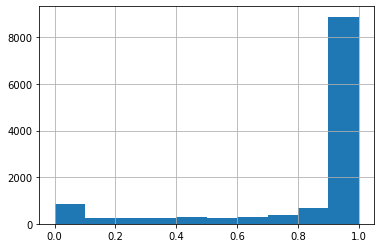

In [379]:
test_df.mean_preds.hist()

In [384]:
test_df['label_idx'] = test_df['label'].map({"REAL":0, "FAKE":1})

In [385]:
test_df.head()

,fname,label,original,source,face_crop_fnames,preds,mean_preds,median_preds,label_idx
0,gthvvygfcj.mp4,FAKE,lxeqbyddvt.mp4,lxeqbyddvt.mp4,"[dfdc_train_part_45/gthvvygfcj/frame_1_30.jpg,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,1.000000,1
1,lxeqbyddvt.mp4,REAL,NaN,lxeqbyddvt.mp4,"[dfdc_train_part_45/lxeqbyddvt/frame_1_30.jpg,...","[0.00022220885148271918, 0.0010630048345774412...",0.011671,0.000573,0
2,rmgmravhdx.mp4,FAKE,lxeqbyddvt.mp4,lxeqbyddvt.mp4,"[dfdc_train_part_45/rmgmravhdx/frame_1_30.jpg,...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.9999998807907104, ...",1.000000,1.000000,1
3,rottyedvaw.mp4,FAKE,lxeqbyddvt.mp4,lxeqbyddvt.mp4,"[dfdc_train_part_45/rottyedvaw/frame_1_30.jpg,...","[0.9999896287918091, 0.9999840259552002, 0.999...",0.999698,0.999994,1
4,ycybtwdpej.mp4,FAKE,lxeqbyddvt.mp4,lxeqbyddvt.mp4,"[dfdc_train_part_45/ycybtwdpej/frame_1_30.jpg,...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.9999990463256836, ...",0.999997,1.000000,1


In [393]:
# mean log loss
-np.mean(np.log(test_df['label_idx']*test_df['mean_preds'] + 
                (1 - test_df['label_idx'])*(1 - test_df['mean_preds'])))

0.19797126161051878

In [402]:
# median log loss
-np.mean(np.log(test_df['label_idx']*test_df['median_preds'] + 
                (1 - test_df['label_idx'])*(1 - test_df['median_preds'])))

0.2965859887731472

In [405]:
# mean accuracy
np.mean(test_df['label_idx'] == (test_df['mean_preds'] > 0.5))

0.9321581628527533

In [407]:
# median accuracy
np.mean(test_df['label_idx'] == (test_df['median_preds'] > 0.5))

0.9305409557693862

In [400]:
from IPython.display import FileLink

In [401]:
FileLink(learner.data.path/learner.model_dir/'single_frame_model_resnet34.pth')

/home/ubuntu/git/dfdc/nbs/models/single_frame_model_resnet34.pth

### export 

In [26]:
from nbdev.export import notebook2script

In [27]:
notebook2script()

Converted 001 - extract_faces.ipynb.
Converted 002 - face_detection_retinaface.ipynb.
Converted 003 - save_face_crops.ipynb.
Converted 004 - tl_baseline.ipynb.
Converted 00_core.ipynb.
Converted 01_video_core.ipynb.
Converted 10_bbox_utils.ipynb.
Converted 11_retinaface_detection.ipynb.
Converted 12_generate_face_detections.ipynb.
Converted 13_save_cropped_faces.ipynb.
Converted 20_datasets.ipynb.
Converted 21_single_frame_model.ipynb.
Converted index.ipynb.
